# data prepping

In [ ]:

# dataprepping
%pip install beautifulsoup4

# Vecotr database
%pip install faiss-cpu
%pip install sentence_transformers

# Ai structure
%pip install langchain langchain_community
%pip install ChatOpenAI
%pip install langgraph langchain-core

In [7]:
def clear_kd_base():
    # Open the file in write mode to clear its contents
    with open('kd_base.json', 'w', encoding='utf-8') as f:
        # Just truncate the file without writing anything
        pass
    print("kd_base.json has been cleared")

#clear_kd_base()

kd_base.json has been cleared


In [8]:
import textwrap
import json
import bs4
import os

def get_context(filename):
    
    # part 1
    #print("this is the filename: ", filename)
    with open(filename, 'r', encoding='utf-8') as f:
        html_doc = f.read()
        file_doc = bs4.BeautifulSoup(html_doc, 'html.parser')

    main_el = file_doc.find("main")
    #print(main_el.prettify())

    title_in_main = main_el.find('h1')
    text_in_main = main_el.find_all('p')

    if title_in_main:
        print(title_in_main.get_text(strip=True))
    else:
        print("Title not found in main")

    print("")
    context = ""
    # remove style tags and <p> tags
    for p in text_in_main:
        #print(p)
        context += p.get_text(strip=True) + "\n"
    print(textwrap.fill(context, width=80))
    
    
    # part 2 save context and title into kd_base.json
    #print(f"\n{filename}")
    id = filename.split('/')[-1].split('-')[0]
    url = filename.split('/')[-1].split('.')[0]
    url = f"www.lysa.se/help-center/{url}"
    print(url)
    print("\n"+"="*80+"\n") 
    item = {
        "id": id,
        "title": title_in_main.get_text(strip=True) if title_in_main else "No title found",
        "context": context,
        "source": url
    }
    return item


    

# files = sorted(os.listdir('support_pages'))
# kd_base = {}
# for i, file in enumerate(files):
#     #print(file)
#     item = get_context(os.path.join('support_pages', file))
#     kd_base[i] = item# 

# # Write to JSON file
# with open('kd_base.json', 'a+', encoding='utf-8') as f:
#     json_str = json.dumps(kd_base, ensure_ascii=False, indent=4)
#     f.write(json_str)

with open('kd_base.json', 'r', encoding='utf-8') as f:
    kd_base = json.load(f)
    print("Loaded", len(kd_base), "items from kd_base.json")

Investera i fonder eller spara på Sparkonto Auto?

Investera i fonderAtt investera i fonder ger möjlighet till god avkastning över
tid. Samtidigt innebär det en risk att pengarna minskar i värde. Hos oss
investeras dina pengar i en portfölj av aktie- och räntefonder som anpassas
efter dina behov. Detta är lämpligt för sparande på minst ett år där möjlighet
till god avkastning är viktigare än låg risk.Dina pengar sätts in på ett ISK
(investeringssparkonto).Spara på Sparkonto AutoSparkonto Auto är en trygg
sparform som innebär att du kan få ränta på dina pengar samtidigt som de är
skyddade av den statliga insättningsgarantin. Det är lämpligt för exempelvis
buffertsparande eller kortsiktiga sparmål där låg risk är viktigare än hög
avkastning.Dina pengar sätts in på ett Sparkonto Auto.
www.lysa.se/help-center/157-investera-i-fonder-eller-spara-pa-sparkonto-auto


Vilka är Lysas samarbetspartners?

Lysa samarbetar för närvarande med Collector (Norion Bank AB) och Borgo för att
tillhandahåll

In [33]:
import numpy as np
import faiss
from langchain_openai import OpenAIEmbeddings
import os
import dotenv

dotenv.load_dotenv()

api_key = os.getenv("OPENAI_API_KEY")

def get_vector_db():

    # Initiera OpenAIEmbeddings med din API-nyckel
    openai_embeddings = OpenAIEmbeddings(openai_api_key=api_key)

    # Skapa en lista med "context" från kd_base
    texts = [item['context'] for item in kd_base.values()]

    # Beräkna embeddings för varje text med OpenAI-modellen
    embeddings = openai_embeddings.embed_documents(texts)
    embeddings = np.array(embeddings).astype('float32')
    d = embeddings.shape[1]

    # Bygg ett FAISS-index för vektorsökning (L2-avstånd)
    index = faiss.IndexFlatL2(d)
    index.add(embeddings)

    print(f"Vector store byggt med {index.ntotal} vektorer.")

    # Spara FAISS-indexet till fil
    faiss.write_index(index, "faiss_index.index")
    print("FAISS-index sparat till 'faiss_index.index'.")

    # Spara embeddings i en NumPy-fil
    np.save("embeddings.npy", embeddings)
    print("Embeddings sparade till 'embeddings.npy'.")

    return openai_embeddings, embeddings, index

get_vector_db()

openai_embeddings = OpenAIEmbeddings(openai_api_key=api_key)
embeddings = np.load("embeddings.npy")
index = faiss.read_index("faiss_index.index")

Vector store byggt med 74 vektorer.
FAISS-index sparat till 'faiss_index.index'.
Embeddings sparade till 'embeddings.npy'.


In [34]:
# Definiera en fråga
query = "vad är lysa?"

# Generera embeddings för frågan med OpenAI
query_embedding = openai_embeddings.embed_query(query)
query_embedding = np.array(query_embedding, dtype='float32').reshape(1, -1)

# Definiera hur många toppresultat vi vill hämta
top_k = 5

# Utför FAISS-sökning
distances, indices = index.search(query_embedding, top_k)

# Skriv ut resultaten
for i, idx in enumerate(indices[0]):
    print(f"Match {i+1}")
    print("Title:", kd_base[str(idx)]["title"])
    print("Context:", kd_base[str(idx)]["context"])
    print("Source:", kd_base[str(idx)]["source"])
    print()


Match 1
Title: Hur kontaktar jag er?
Context: Har du frågor om Lysa? Något vi kan förbättra eller bara säga hej? Hör gärna av dig, via mejl eller telefon direkt.Telefon:010 551 32 30vardagar mellan 09:00-18:00Meddelande och mejl: vardagar mellan 09:00-18:00Du kan även skicka ett meddelande sominloggad kund direkthär.Mejl:kontakt@lysa.seÄr du företagare? Tveka inte kontakta oss direkthär:foretag@lysa.se



Source: www.lysa.se/help-center/81-hur-kontaktar-jag-er

Match 2
Title: Varför flytta pension till Lysa och hur gör jag?
Context: Varför ska man flytta till Lysa?1)Du får Lysas evidensbaserade förvaltning även för din pension.Precis som för ditt privata sparande får du Lysas automatiska förvaltning även för de tjänstepensioner du flyttar till Lysa. Välj mellan vårt breda och hållbara investeringsfokus och den risk du är bekväm med så ser vi därefter till att dina pengar investeras i en bred, global och billig portfölj. När flytten till Lysa är genomförd, investeras pengarna automatisk

In [17]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="gpt-4o")

In [18]:
def calculate_percentage(value: float, total: float) -> float:
    """Returns the percentage of value relative to total.
    
    Args:
        value (float): The value to calculate percentage.
        total (float): The total value.
    """
    if total == 0:
        return 0.0
    return (value / total) * 100

def percentage_of_value(percent: float, amount: float) -> float:
    """Returns the percentage of amount based on percent.
    
    Args:
        percent (float): The percentage value.
        amount (float): The total amount.
    """
    return (percent / 100.0) * amount

In [21]:
def search(query: str, top_k: int = 10) -> list:
    """
    Utför en vektorsökning över kunskapsbasen av frågor (kd_base) med hjälp av den globala modellen och FAISS-indexet.

    Args:
    query (str): Frågesträngen att söka efter.
    top_k (int, valfritt): Antal toppresultat att returnera. Standard är 5.

    Returns:
    list: En lista med ordböcker, där varje ordbok innehåller "title", "context" och "distance" för ett resultat.
    """
    if not query.strip():
        return []

    # Encode query using OpenAI embeddings.
    # Note: OpenAIEmbeddings.embed_query returns a list of floats.
    embedding_vector = openai_embeddings.embed_query(query)
    # Convert to a numpy array of type float32 and reshape to (1, -1)
    embedding = np.array(embedding_vector, dtype='float32').reshape(1, -1)
    
    distances, indices = index.search(embedding, top_k)

    results = []
    for i, idx in enumerate(indices[0]):
        idx_int = int(idx)
        try:
            entry = kd_base[idx_int] if isinstance(kd_base, list) else list(kd_base.values())[idx_int]
        except (IndexError, KeyError):
            continue

        results.append({
            "title": entry.get("title", "No Title"),
            "context": entry.get("context", "No Context"),
            "source": entry.get("source", "No Source"),
            "distance": float(distances[0][i])
        })

    return results



In [22]:
tools = [percentage_of_value, calculate_percentage, search]

llm_with_tools = llm.bind_tools(tools)

In [23]:
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

sys_msg = SystemMessage(
    "Hej! Jag är en kundsupportagent och kan hjälpa dig med grundläggande information om vår tjänst, Lysa. "
    "Om jag inte har svaret på din fråga, hänvisar jag dig gärna till vår kundsupport för vidare hjälp."
)


In [24]:
# Node
def reasoner(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

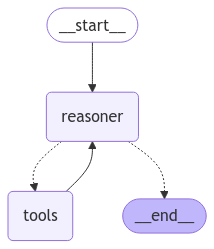

In [25]:
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# Graph 
builder = StateGraph(MessagesState)

# Add nodes 
builder.add_node("reasoner", reasoner)
builder.add_node("tools", ToolNode(tools))

# Add edges
builder.add_edge(START, "reasoner")
builder.add_conditional_edges(
    "reasoner",
    tools_condition,
)
builder.add_edge("tools", "reasoner")
react_graph = builder.compile()

# Display the graph
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))


In [26]:
messages = [HumanMessage(content="vad är avgiften för att använda lysa?")]
messages = react_graph.invoke({"messages": messages})

In [27]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

vad är avgiften för att använda lysa?
================================== Ai Message ==================================

Lysa har en total avgift som består av tre delar:

1. **Förvaltningsavgift:** Lysa tar ut en förvaltningsavgift som kan variera beroende på hur mycket pengar du har investerat. Avgiften ligger vanligtvis mellan 0,24% och 0,39% per år.

2. **Fondavgifter:** Dessa är de underliggande avgifterna för de fonder som ingår i din portfölj. Dessa avgifter varierar beroende på vilka fonder som används men ligger ofta runt 0,10% till 0,15% per år.

3. **Kostnader för handel:** Det kan även finnas små kostnader relaterade till handel inom din portfölj.

Det är alltid bra att besöka Lysas officiella webbplats eller kontakta deras kundtjänst för att få den mest aktuella och detaljerade informationen om avgifter.


In [28]:
messages = [HumanMessage(content="hur mycket avgiften för att använda lysa om jag har 356230,54kr?")]
messages = react_graph.invoke({"messages": messages})

In [29]:
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

hur mycket avgiften för att använda lysa om jag har 356230,54kr?
================================== Ai Message ==================================

Lysa har en avgiftsstruktur som består av två delar: Lysas egen avgift och fondavgifter. Den totala avgiften ligger vanligtvis mellan 0,3% och 0,4% per år. För en mer exakt beräkning, låt oss anta att den totala avgiften är 0,35%. 

Skulle du vilja att jag räknar ut det exakta beloppet för dig baserat på denna procentsats?


## More complexity with routing difficult questions away from model.

In [ ]:
#If the agent can't answer the question, it will recommend the customer to contact the customer support.
messages = [HumanMessage(content="jag vill att ni stänger av mitt konto")]
messages = react_graph.invoke({"messages": messages})

msg = ""
for m in messages["messages"]:
    # Access specific properties of the message
    if hasattr(m, 'content'):
        msg += f"Content: {m.content}\n"
    if hasattr(m, 'type'):
        msg += f"Type: {m.type}\n"
    if hasattr(m, 'role'):
        msg += f"Role: {m.role}\n"
    msg += "="*80 + "\n\n"  # Separator between messages
    
    # The pretty_print() can stay as is
    m.pretty_print()

In [1]:
!pip install discord
!pip install streamlit-jupyter


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.2/13.2 MB 10.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 11.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 11.2 MB/s eta 0:00:00 0:00:01
  Attempting uninstall: jupyterlab-widgets
    Found existing installation: jupyterlab_widgets 3.0.13
    Uninstalling jupyterlab_widgets-3.0.13:
      Successfully uninstalled jupyterlab_widgets-3.0.13
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 4.0.13
    Uninstalling widgetsnbextension-4.0.13:
      Successfully uninstalled widgetsnbextension-4.0.13
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 8.1.5
    Uninstalling ipywidgets-8.1.5:
      Successfully uninstalled ipywidgets-8.1.5


# Use later

In [ ]:
# import requests
# from dotenv import load_dotenv
# 
# webhook_url = os.getenv("DISCORD_WEBHOOK_URL")
# 
# requests.post(webhook_url, data={"content":"Just testing!"})

In [ ]:
# requests.post(webhook_url, data={"content":msg})

In [5]:
!pip uninstall streamlit-jupyter -y
!pip install streamlit-jupyter


Found existing installation: streamlit-jupyter 0.2.1
Uninstalling streamlit-jupyter-0.2.1:
  Successfully uninstalled streamlit-jupyter-0.2.1
  Using cached streamlit_jupyter-0.2.1-py3-none-any.whl.metadata (8.1 kB)
Using cached streamlit_jupyter-0.2.1-py3-none-any.whl (13 kB)


In [12]:
import streamlit as st
from streamlit_jupyter import StreamlitPatcher
from langchain_core.messages import HumanMessage

# Enable Streamlit components in Jupyter
StreamlitPatcher().jupyter()

# Use Streamlit as usual
st.title("Interactive App")

user_query = st.text_input("Enter your query:")

if st.button("Send"):
    if user_query:
        messages = [HumanMessage(content=user_query)]
        response = react_graph.invoke({"messages": messages})
        for m in response["messages"]:
            st.write(m.content)
    else:
        st.write("Please enter a query.")


# Interactive App

Textarea(value='', description='Enter your query:', placeholder='Type something')

2025-02-05 01:08:17.603 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-05 01:08:17.604 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-05 01:08:17.604 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-05 01:08:17.605 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-05 01:08:17.627 
  command:

    streamlit run /home/morrissimons/miniconda3/lib/python3.12/site-packages/ipykernel_launcher.py [ARGUMENTS]
2025-02-05 01:08:17.627 Thread 'MainThread': missing ScriptRunContext! This warning can 

In [4]:
import streamlit_jupyter
print(dir(streamlit_jupyter))


['IN_IPYTHON', 'StreamlitPatcher', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', '__version__', 'core', 'tqdm', 'utils']
